In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray

np.random.seed(42)

c:\Users\HP\anaconda3\envs\tf\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def scale_df(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled, index=df.index, columns=df.columns)
    return scaled_df

def split_df(series, split_index):    
    train = series[:split_index]
    test = series[split_index:]

    return train, test

In [3]:
#process oil data
oil_df = pd.read_csv("../datasets/consolidated_data/oil_data.csv", index_col="DATEPRD")
date = oil_df.index
scaled_oil_data = scale_df(oil_df).BORE_OIL_VOL.to_numpy()

oil_date_train, oil_date_test = split_df(date, 2140)
oil_train, oil_test = split_df(scaled_oil_data, 2140)

#process gas data
gas_df = pd.read_csv("../datasets/consolidated_data/gas_data.csv", index_col="DATEPRD")
date = gas_df.index
scaled_gas_data = scale_df(gas_df).BORE_GAS_VOL.to_numpy()

gas_date_train, gas_date_test = split_df(date, 2140)
gas_train, gas_test = split_df(scaled_gas_data, 2140)

print(oil_train.shape, oil_test.shape, oil_date_train.shape, oil_date_test.shape)
print(gas_train.shape, gas_test.shape, gas_date_train.shape, gas_date_test.shape)


(2140,) (916,) (2140,) (916,)
(2140,) (916,) (2140,) (916,)


In [4]:
split_date = 2140

def refresh():
    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)

class ResetStatesCallback(Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()
        
#function to plot a series
def plot_series(x, y, type_=None, ylabel=None, format="-", start=None, end=None, label=None, multi_plot=True):
    if not multi_plot:
        plt.figure(figsize=(20, 10))
    plt.plot(x[start:end], y[start:end], format, label=label)
    plt.xlabel("Date", labelpad=50, fontsize=14)
    plt.ylabel(f"{ylabel} Volume", labelpad=50, fontsize=14)
    if label:
        plt.legend(fontsize=14)
    plt.grid(True, which='both')
    x_ticks = x.to_list()
    x_max = max(x_ticks)
    x_ticks = x_ticks[::round(len(x_ticks)/10)]
    x_ticks.append(x_max)
    plt.xticks(x_ticks, rotation = 30)
    if not multi_plot:
        plt.savefig(f'../plots/{ylabel.lower()}/{ylabel.lower()}_{type_}_time_series.png')
        plt.show()


def sequential_window_dataset(series, window_size):
    
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=window_size, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[1:]))
    
    return dataset.batch(1).prefetch(1)

def train_model(train_dataset, validation_dataset, num_units):
    model = Sequential([
                    LSTM(num_units, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
                    LSTM(num_units, return_sequences=True, stateful=True),
                    Dense(1)
                    ])
    optimizer = keras.optimizers.SGD(
                    learning_rate=1e-3, 
                    momentum=0.9
                    )
    model.compile(
                loss=keras.losses.Huber(), 
                optimizer=optimizer, 
                metrics=["mae"]
                )
    
    reset_states = ResetStatesCallback()
    
    model_checkpoint = ModelCheckpoint(
                                "lstm/LSTM_optimized_checkpoint.h5", 
                                save_best_only=True
                                )
    
    early_stopping = EarlyStopping(patience=50)
    
    model.fit(
            train_dataset, 
            epochs=500, 
            verbose=0,
            validation_data=validation_dataset,
            callbacks=[
                    early_stopping, 
                    model_checkpoint, 
                    reset_states
                    ]
            )

    return model

def train_evaluate(ga_individual_solution):   
    # Decode GA solution to integer for window_size and num_units
    window_size_bits = BitArray(ga_individual_solution[0:6])
    num_units_bits = BitArray(ga_individual_solution[6:]) 
    window_size = window_size_bits.uint
    num_units = num_units_bits.uint
    print('\nWindow Size: ', window_size, ', Num of Units: ', num_units)
    
    # Return fitness score of 100 if window_size or num_unit is zero
    if window_size == 0 or num_units == 0:
        return 100, 
    
    # Segment the train_data based on new window_size; split into train and validation (80/20)
    refresh()

    oil_train_set = sequential_window_dataset(oil_train, window_size)
    oil_test_set = sequential_window_dataset(oil_test, window_size)
    
    # Train LSTM model and predict on validation set
    model = train_model(oil_train_set, oil_test_set, num_units)
    
    #load best model
    model = keras.models.load_model("lstm/LSTM_optimized_checkpoint.h5")
    LSTM_oil_forecast = model.predict(scaled_oil_data[np.newaxis, :, np.newaxis])
    LSTM_oil_forecast = LSTM_oil_forecast[0, split_date - 1:-1, 0]

    # # Calculate the RMSE score as fitness score for GA
    mae = keras.metrics.mean_absolute_error(oil_test, LSTM_oil_forecast).numpy()
    mse = keras.metrics.mean_squared_error(oil_test, LSTM_oil_forecast).numpy()
    rmse = math.sqrt(mse)

    print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')
    
    return rmse,

In [7]:
population_size = 4
num_generations = 4
gene_length = 12

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)

c:\Users\HP\anaconda3\envs\tf\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\HP\anaconda3\envs\tf\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Window Size:  28 , Num of Units:  29
mae = 0.02247031219303608, 
mse = 0.0018145223148167133, 
rmse = 0.04259721017645068

Window Size:  33 , Num of Units:  8
mae = 0.025818482041358948, 
mse = 0.0018240560311824083, 
rmse = 0.04270896897821824

Window Size:  22 , Num of Units:  39
mae = 0.022821784019470215, 
mse = 0.0016214773058891296, 
rmse = 0.04026757139298482

Window Size:  8 , Num of Units:  21
mae = 0.02381877414882183, 
mse = 0.0013868303503841162, 
rmse = 0.037240171191659635

Window Size:  8 , Num of Units:  29
mae = 0.022381993010640144, 
mse = 0.0013430832186713815, 
rmse = 0.03664809979618836

Window Size:  28 , Num of Units:  21
mae = 0.022437743842601776, 
mse = 0.0017167505575343966, 
rmse = 0.041433688678832306

Window Size:  1 , Num of Units:  5
mae = 0.03269059211015701, 
mse = 0.002177265239879489, 
rmse = 0.046661174866043494

Window Size:  60 , Num of Units:  24
mae = 0.027034392580389977, 
mse = 0.0021483362652361393, 
rmse = 0.04635014849206137

Window Size: 

In [8]:
best_individuals = tools.selBest(population, k = 1)
best_window_size = None
best_num_units = None

for bi in best_individuals:
    window_size_bits = BitArray(bi[0:6])
    num_units_bits = BitArray(bi[6:]) 
    best_window_size = window_size_bits.uint
    best_num_units = num_units_bits.uint
    print('\nWindow Size: ', best_window_size, ', Num of Units: ', best_num_units)


Window Size:  16 , Num of Units:  22


In [ ]:
# Window Size:  194 , Num of Units:  143
best_window_size = 8
best_num_units = 29

refresh()

oil_train_set = sequential_window_dataset(oil_train, best_window_size)
oil_test_set = sequential_window_dataset(oil_test, best_window_size)

model = Sequential([
                LSTM(best_num_units, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
                LSTM(best_num_units, return_sequences=True, stateful=True),
                Dense(1)
                ])
optimizer = keras.optimizers.SGD(
                learning_rate=1e-3, 
                momentum=0.9
                )
model.compile(
            loss=keras.losses.Huber(), 
            optimizer=optimizer, 
            metrics=["mae"]
            )

reset_states = ResetStatesCallback()

model_checkpoint = ModelCheckpoint(
                            "lstm/LSTM_optimized_checkpoint.h5", 
                            save_best_only=True
                            )

early_stopping = EarlyStopping(patience=50)

history = model.fit(
        oil_train_set, 
        epochs=500, 
        verbose=1,
        validation_data=oil_test_set,
        callbacks=[
                early_stopping, 
                model_checkpoint, 
                reset_states
                ]
        )

model = keras.models.load_model("lstm/LSTM_optimized_checkpoint.h5")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, None, 29)             3596      
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 29)             6844      
_________________________________________________________________
dense (Dense)                (1, None, 1)              30        
Total params: 10,470
Trainable params: 10,470
Non-trainable params: 0
_________________________________________________________________


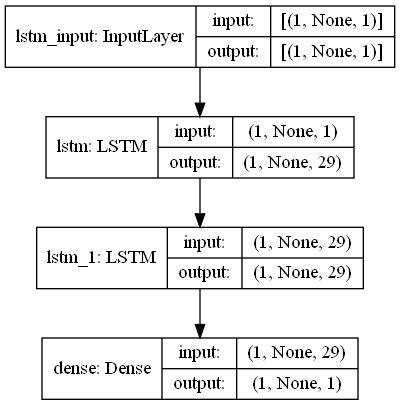

In [4]:
model = keras.models.load_model("lstm/LSTM_optimized_checkpoint.h5")

model.summary()
# Model Architecture
keras.utils.plot_model(model, f'../plots/lstm_optimized_model_plot.png', show_shapes = True)

In [ ]:
# Plotting the loss model
plt.figure(figsize=(20, 10))
plt.plot(history.history["loss"])
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(f'../plots/optimized_loss_model.png')
plt.show()

mae = 0.022381993010640144, 
mse = 0.0013430832186713815, 
rmse = 0.03664809979618836


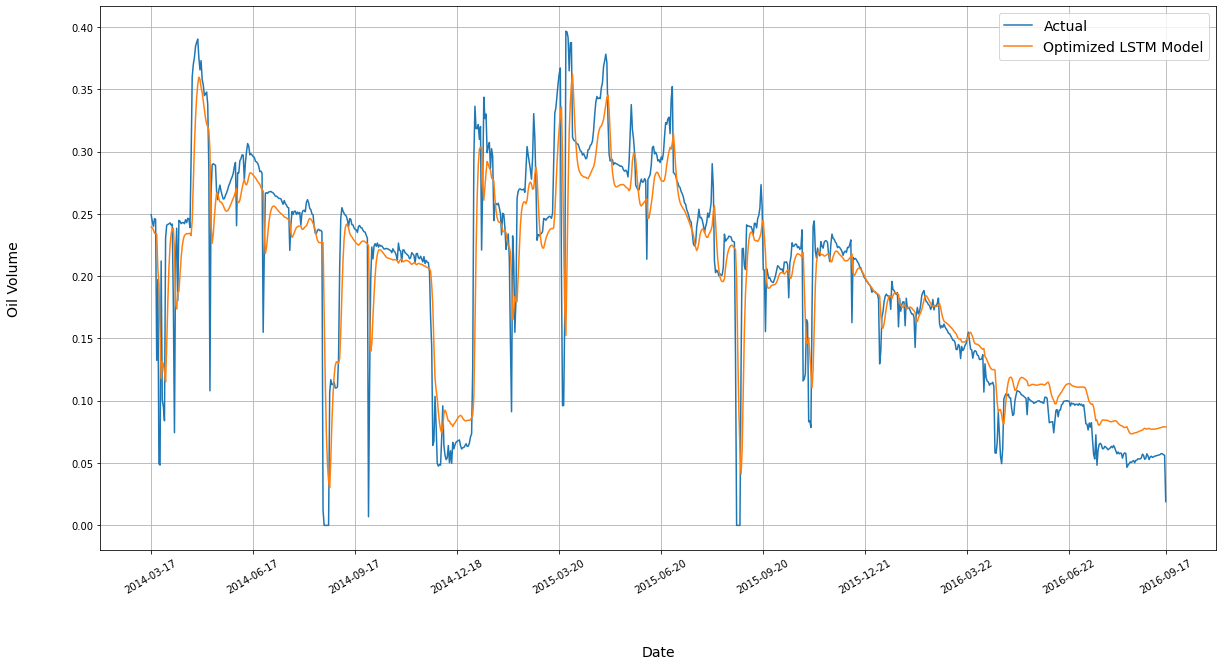

In [26]:
LSTM_oil_forecast = model.predict(scaled_oil_data[np.newaxis, :, np.newaxis])
LSTM_oil_forecast = LSTM_oil_forecast[0, 2140 - 1:-1, 0]

# Calculate the RMSE score as fitness score for GA
mae = keras.metrics.mean_absolute_error(oil_test, LSTM_oil_forecast).numpy()
mse = keras.metrics.mean_squared_error(oil_test, LSTM_oil_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

plt.figure(figsize=(20, 10))

plot_series(oil_date_test, oil_test, ylabel="Oil", label="Actual")
plot_series(oil_date_test, LSTM_oil_forecast, ylabel="Oil", label="Optimized LSTM Model")

plt.savefig(f'../plots/oil/oil_lstm_optimized_forecast.png')
plt.show()

mae = 0.022628383710980415, 
mse = 0.001392168807797134, 
rmse = 0.03731177840571438


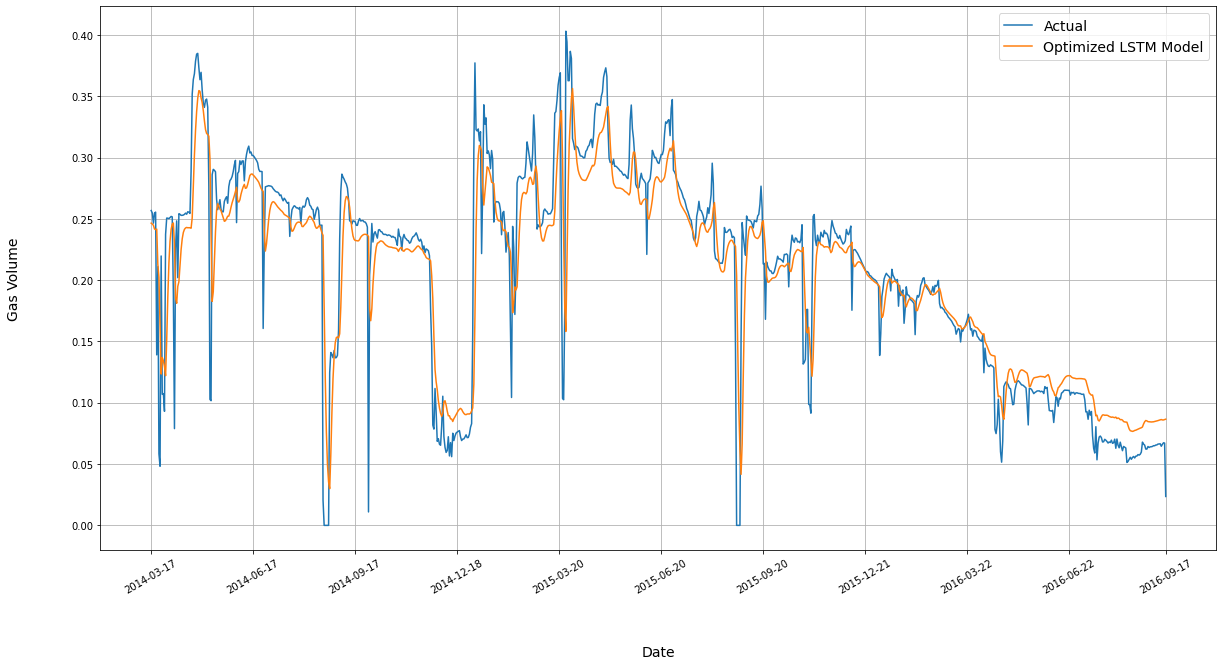

In [25]:
LSTM_gas_forecast = model.predict(scaled_gas_data[np.newaxis, :, np.newaxis])
LSTM_gas_forecast = LSTM_gas_forecast[0, 2140 - 1:-1, 0]

# Calculate the RMSE score as fitness score for GA
mae = keras.metrics.mean_absolute_error(gas_test, LSTM_gas_forecast).numpy()
mse = keras.metrics.mean_squared_error(gas_test, LSTM_gas_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

plt.figure(figsize=(20, 10))

plot_series(gas_date_test, gas_test, ylabel="Gas", label="Actual")
plot_series(gas_date_test, LSTM_gas_forecast, ylabel="Gas", label="Optimized LSTM Model")

plt.savefig(f'../plots/gas/gas_lstm_optimized_forecast.png')
plt.show()